# **Section 2 Project: 현대자동차 주가 분석**

##**목표**

**데이터셋을 사용하여 머신러닝 모델을 만든 후 성능 및 인사이트를 도출/공유하는 것**

##**절차**

1. 데이터 선정 이유 및 문제 정의
2. 데이터를 이용한 가설 및 평가지표, 베이스라인 선택
3. EDA와 전처리
4. 머신러닝 방식 적용 및 교차검증
5. 머신러닝 모델 해석

# **데이터 선정**

**데이터**: 현대자동차 주가(2000-01-04 ~ 2021-08-31) 

**참조 데이터**: 
1. 삼성전자, 기아자동차 주가
2. 주요국 환율(USD/JPY/EUR/GBP)
3. 금 가격, 원유 가격
4. 주가지수(한국/미국/일본/프랑스/독일) 

**선정이유**: 특성별 등락여부에 따른 현대자동차 주가의 등락여부를 확인하기 위함.

**출처**
1. 야후 파이낸스(https://finance.yahoo.com)
2. 한국은행 경제통계시스템(https://ecos.bok.or.kr/)

### **데이터 불러오기**

In [274]:
# 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [275]:
# 판다스 라이브러리 불러오기
import pandas as pd
# 데이터 불러오기
## 증권 데이터
HMG = pd.read_csv('/content/drive/MyDrive/hyundae_motor_company.csv') # Hyundai_Motor_Group
SAM = pd.read_csv('/content/drive/MyDrive/Samsung_Electronics_Co.csv') # Samsung_Electronics
KIA = pd.read_csv('/content/drive/MyDrive/kia_corporation.csv') # KIA_Corporation
## 환율
USD = pd.read_csv('/content/drive/MyDrive/USD.csv', encoding='CP949') # currency of KRW-USD
CNY_JPY_EUR_GBP = pd.read_csv('/content/drive/MyDrive/KRW_CNY_JPY_EUR_GBP.csv', encoding='CP949') # Currency of KRW-CNY, JPY, EUR and GBP
## 원자재
GOLD = pd.read_csv('/content/drive/MyDrive/gold.csv') # Gold
OIL = pd.read_csv('/content/drive/MyDrive/crude_oil.csv') # Crude_Oil
## 지수
KOSPI = pd.read_csv('/content/drive/MyDrive/KOSPI.csv') # ROK KOSPI
NASDAQ = pd.read_csv('/content/drive/MyDrive/NASDAQ.csv') # US NASDAQ
NY_DJI_SP500 = pd.read_csv('/content/drive/MyDrive/ny.csv') # US Dow_Jones_Industries, S&P_500
NIKKEI = pd.read_csv('/content/drive/MyDrive/JP.csv') # Japan Nikkei_225
DAX = pd.read_csv('/content/drive/MyDrive/GER.csv') # Germany DAX_50
CAC = pd.read_csv('/content/drive/MyDrive/FR.csv') # France CAC_40

### **라이브러리**

In [276]:
!pip install eli5
!pip install category_encoders
!pip install pdpbox
!pip install shap

In [277]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# **데이터 확인**

## **데이터셋 합치기**

### **증권 데이터**

In [278]:
# 현대자동차 증권 데이터 확인
HMG['Date'] = pd.to_datetime(HMG['Date'])
HMG.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1, inplace=True)
HMG.columns = ['Date', 'HMG Price', 'HMG Volume']
HMG.set_index('Date', inplace=True)
HMG

,HMG Price,HMG Volume
Date,,
2000-01-04,20700.0,2028300.0
2000-01-05,20800.0,4091600.0
2000-01-06,19700.0,1899300.0
2000-01-07,20300.0,2206900.0
2000-01-10,20000.0,1931800.0
...,...,...
2021-08-25,209500.0,477019.0
2021-08-26,210000.0,417323.0
2021-08-27,208500.0,502218.0


In [279]:
# 삼성전자 주식데이터 확인
SAM['Date'] = pd.to_datetime(SAM['Date'])
SAM.set_index('Date', inplace=True)
SAM.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
SAM.columns=['Samsung Stock Price']
SAM

,Samsung Stock Price
Date,
2000-01-04,6110.0
2000-01-05,5580.0
2000-01-06,5620.0
2000-01-07,5540.0
2000-01-10,5770.0
...,...
2021-08-25,75700.0
2021-08-26,74600.0
2021-08-27,74300.0


In [280]:
# 기아자동차 주식데이터 확인 및 가공
KIA['Date'] = pd.to_datetime(KIA['Date'])
KIA.set_index('Date', inplace=True)
KIA.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
KIA.columns=['KIA Stock Price']
KIA

,KIA Stock Price
Date,
2000-01-04,7665.0
2000-01-05,7248.0
2000-01-06,6935.0
2000-01-07,6779.0
2000-01-10,7092.0
...,...
2021-08-25,81600.0
2021-08-26,82000.0
2021-08-27,82100.0


In [281]:
stock = pd.concat([HMG, SAM, KIA], axis=1)
stock

,HMG Price,HMG Volume,Samsung Stock Price,KIA Stock Price
Date,,,,
2000-01-04,20700.0,2028300.0,6110.0,7665.0
2000-01-05,20800.0,4091600.0,5580.0,7248.0
2000-01-06,19700.0,1899300.0,5620.0,6935.0
2000-01-07,20300.0,2206900.0,5540.0,6779.0
2000-01-10,20000.0,1931800.0,5770.0,7092.0
...,...,...,...,...
2021-08-25,209500.0,477019.0,75700.0,81600.0
2021-08-26,210000.0,417323.0,74600.0,82000.0
2021-08-27,208500.0,502218.0,74300.0,82100.0


### **환율 데이터**

In [282]:
USD.drop([0,1,2,5421,5422,5423,5424], inplace=True)
USD.reset_index(inplace=True)
USD.drop(['index'],axis=1, inplace=True)
USD.columns = ['Date', 'USD']
USD['Date'] = pd.to_datetime(USD['Date'])
USD.set_index('Date', inplace=True)
USD

,USD
Date,
2000-01-04,1134.50
2000-01-05,1125.80
2000-01-06,1130.10
2000-01-07,1139.10
2000-01-08,1145.90
...,...
2021-08-25,1168.00
2021-08-26,1166.50
2021-08-27,1168.10


In [283]:
CNY_JPY_EUR_GBP.drop([0,1,2,5421,5422,5423,5424], inplace=True)
CNY_JPY_EUR_GBP.reset_index(inplace=True)
CNY_JPY_EUR_GBP.drop(['index', 'Unnamed: 5'],axis=1, inplace=True)
CNY_JPY_EUR_GBP.columns = ['Date', 'CNY', 'JPY', 'EUR', 'GBP']
CNY_JPY_EUR_GBP['Date'] = pd.to_datetime(CNY_JPY_EUR_GBP['Date'])
CNY_JPY_EUR_GBP.set_index('Date', inplace=True)
CNY_JPY_EUR_GBP

,CNY,JPY,EUR,GBP
Date,,,,
2000-01-04,NaN,1115.00,1162.00,1856.00
2000-01-05,NaN,1091.00,1159.00,1843.00
2000-01-06,NaN,1086.00,1166.00,1855.00
2000-01-07,NaN,1082.00,1175.00,1876.00
2000-01-08,NaN,1088.00,1179.00,1877.00
...,...,...,...,...
2021-08-25,180.00,1065.00,1373.00,1603.00
2021-08-26,180.00,1060.00,1373.00,1605.00
2021-08-27,181.00,1061.00,1373.00,1601.00


In [284]:
currency = pd.concat([USD, CNY_JPY_EUR_GBP], axis=1)
currency

,USD,CNY,JPY,EUR,GBP
Date,,,,,
2000-01-04,1134.50,NaN,1115.00,1162.00,1856.00
2000-01-05,1125.80,NaN,1091.00,1159.00,1843.00
2000-01-06,1130.10,NaN,1086.00,1166.00,1855.00
2000-01-07,1139.10,NaN,1082.00,1175.00,1876.00
2000-01-08,1145.90,NaN,1088.00,1179.00,1877.00
...,...,...,...,...,...
2021-08-25,1168.00,180.00,1065.00,1373.00,1603.00
2021-08-26,1166.50,180.00,1060.00,1373.00,1605.00
2021-08-27,1168.10,181.00,1061.00,1373.00,1601.00


In [285]:
def to_str(string):
    return str(string)
def to_float(string):
    return float(string.replace(',',''))

In [286]:
currency['USD'] = currency['USD'].apply(to_str)
currency['CNY'] = currency['CNY'].apply(to_str)
currency['JPY'] = currency['JPY'].apply(to_str)
currency['EUR'] = currency['EUR'].apply(to_str)
currency['GBP'] = currency['GBP'].apply(to_str)
currency['USD'] = currency['USD'].apply(to_float)
currency['CNY'] = currency['CNY'].apply(to_float)
currency['JPY'] = currency['JPY'].apply(to_float)
currency['EUR'] = currency['EUR'].apply(to_float)
currency['GBP'] = currency['GBP'].apply(to_float)
currency

,USD,CNY,JPY,EUR,GBP
Date,,,,,
2000-01-04,1134.5,NaN,1115.0,1162.0,1856.0
2000-01-05,1125.8,NaN,1091.0,1159.0,1843.0
2000-01-06,1130.1,NaN,1086.0,1166.0,1855.0
2000-01-07,1139.1,NaN,1082.0,1175.0,1876.0
2000-01-08,1145.9,NaN,1088.0,1179.0,1877.0
...,...,...,...,...,...
2021-08-25,1168.0,180.0,1065.0,1373.0,1603.0
2021-08-26,1166.5,180.0,1060.0,1373.0,1605.0
2021-08-27,1168.1,181.0,1061.0,1373.0,1601.0


### **원자재 데이터**

In [287]:
GOLD.drop([5236], inplace=True)
GOLD.drop(['Open', 'High', 'Low', 'Adj Close**', 'Volume'], axis=1, inplace=True)
GOLD.columns = ['Date', 'Gold Price']
GOLD['Date'] = pd.to_datetime(GOLD['Date'])
GOLD.set_index('Date', inplace=True)
GOLD

,Gold Price
Date,
2000-08-31,278.3
2000-09-01,277.0
2000-09-05,275.8
2000-09-06,274.2
2000-09-07,274.0
...,...
2021-08-25,1788.2
2021-08-26,1792.2
2021-08-27,1816.6


In [288]:
OIL.drop(['Open', 'High', 'Low', 'Adj Close**', 'Volume'], axis=1, inplace=True)
OIL.columns = ['Date', 'Oil Price']
OIL['Date'] = pd.to_datetime(OIL['Date'])
OIL.set_index('Date', inplace=True)
OIL['Oil Price'] = OIL['Oil Price'].apply(to_str)
OIL['Oil Price'] = OIL['Oil Price'].apply(to_float)
OIL

,Oil Price
Date,
2000-08-24,31.63
2000-08-25,32.05
2000-08-28,32.87
2000-08-29,32.72
2000-08-30,33.40
...,...
2021-08-25,68.36
2021-08-26,67.42
2021-08-27,68.74


In [289]:
raw_materials = pd.concat([GOLD, OIL], axis=1)
raw_materials

,Gold Price,Oil Price
Date,,
2000-08-24,NaN,31.63
2000-08-25,NaN,32.05
2000-08-28,NaN,32.87
2000-08-29,NaN,32.72
2000-08-30,NaN,33.40
...,...,...
2021-08-25,1788.2,68.36
2021-08-26,1792.2,67.42
2021-08-27,1816.6,68.74


### **지수 데이터**

In [290]:
# KOSPI 데이터 가공
KOSPI.drop(['Open','High','Low','Adj Close','Volume'], axis=1, inplace=True)
KOSPI.columns = ['Date', 'KOSPI']
KOSPI['Date'] = pd.to_datetime(KOSPI['Date'])
KOSPI.set_index('Date', inplace=True)
# NASDAQ 데이터 가공
NASDAQ.drop(['Open','High','Low','Adj Close','Volume'], axis=1, inplace=True)
NASDAQ.columns = ['Date', 'NASDAQ']
NASDAQ['Date'] = pd.to_datetime(NASDAQ['Date'])
NASDAQ.set_index('Date', inplace=True)
# DJI, S&P 500 데이터 가공
NY_DJI_SP500.drop([5450], inplace=True)
NY_DJI_SP500['Date'] = pd.to_datetime(NY_DJI_SP500['Date'])
NY_DJI_SP500.set_index('Date', inplace=True)
# NIKKEI 225 데이터 가공
NIKKEI.drop(['Open','High','Low','Adj Close','Volume'], axis=1, inplace=True)
NIKKEI.columns = ['Date', 'NIKKEI 225']
NIKKEI['Date'] = pd.to_datetime(NIKKEI['Date'])
NIKKEI.set_index('Date', inplace=True)
# DAX 50 데이터 가공
DAX.drop(['Open','High','Low','Adj Close','Volume'], axis=1, inplace=True)
DAX.columns = ['Date', 'DAX50']
DAX['Date'] = pd.to_datetime(DAX['Date'])
DAX.set_index('Date', inplace=True)
# CAC 40 데이터 가공
CAC.drop(['Open','High','Low','Adj Close','Volume'], axis=1, inplace=True)
CAC.columns = ['Date', 'CAC40']
CAC['Date'] = pd.to_datetime(CAC['Date'])
CAC.set_index('Date', inplace=True)
# 데이터 합치기
stock_index = pd.concat([KOSPI, NY_DJI_SP500, NASDAQ, NIKKEI, DAX, CAC], axis=1)
stock_index

,KOSPI,DJI,S&P500,NASDAQ,NIKKEI 225,DAX50,CAC40
Date,,,,,,,
2000-01-04,1059.04,10997.93,1399.42,3901.69,19003.0,6586.95,5672.02
2000-01-05,986.31,11122.65,1402.11,3877.54,18543.0,6502.07,5479.70
2000-01-06,960.79,11253.26,1403.45,3727.13,18168.0,6474.92,5450.11
2000-01-07,948.65,11522.56,1441.47,3882.62,18193.0,6780.96,5539.61
2000-01-10,987.24,11572.20,1457.60,4049.67,NaN,6925.52,5646.12
...,...,...,...,...,...,...,...
2021-08-25,3146.81,35405.50,4496.19,15041.86,27725.0,15860.66,6676.48
2021-08-26,3128.53,35213.12,4470.00,14945.81,27742.0,15793.62,6666.03
2021-08-27,3133.90,35455.80,4509.37,15129.50,27641.0,15851.75,6681.92


### **프로젝트 기초 데이터**

In [291]:
df = pd.concat([stock, currency, raw_materials, stock_index], axis=1)
df = df.fillna(method='bfill')

In [292]:
df

,HMG Price,HMG Volume,Samsung Stock Price,KIA Stock Price,USD,CNY,JPY,EUR,GBP,Gold Price,Oil Price,KOSPI,DJI,S&P500,NASDAQ,NIKKEI 225,DAX50,CAC40
Date,,,,,,,,,,,,,,,,,,
2000-01-04,20700.0,2028300.0,6110.0,7665.0,1134.5,178.0,1115.0,1162.0,1856.0,278.3,31.63,1059.04,10997.93,1399.42,3901.69,19003.0,6586.95,5672.02
2000-01-05,20800.0,4091600.0,5580.0,7248.0,1125.8,178.0,1091.0,1159.0,1843.0,278.3,31.63,986.31,11122.65,1402.11,3877.54,18543.0,6502.07,5479.70
2000-01-06,19700.0,1899300.0,5620.0,6935.0,1130.1,178.0,1086.0,1166.0,1855.0,278.3,31.63,960.79,11253.26,1403.45,3727.13,18168.0,6474.92,5450.11
2000-01-07,20300.0,2206900.0,5540.0,6779.0,1139.1,178.0,1082.0,1175.0,1876.0,278.3,31.63,948.65,11522.56,1441.47,3882.62,18193.0,6780.96,5539.61
2000-01-08,20000.0,1931800.0,5770.0,7092.0,1145.9,178.0,1088.0,1179.0,1877.0,278.3,31.63,987.24,11572.20,1457.60,4049.67,18851.0,6925.52,5646.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-25,209500.0,477019.0,75700.0,81600.0,1168.0,180.0,1065.0,1373.0,1603.0,1788.2,68.36,3146.81,35405.50,4496.19,15041.86,27725.0,15860.66,6676.48
2021-08-26,210000.0,417323.0,74600.0,82000.0,1166.5,180.0,1060.0,1373.0,1605.0,1792.2,67.42,3128.53,35213.12,4470.00,14945.81,27742.0,15793.62,6666.03
2021-08-27,208500.0,502218.0,74300.0,82100.0,1168.1,181.0,1061.0,1373.0,1601.0,1816.6,68.74,3133.90,35455.80,4509.37,15129.50,27641.0,15851.75,6681.92


- 데이터는 1일 단위로 기록되어 있다.

# **가설**

**가설1: 현대자동차의 주가와 타사 주가와의 상관관계**
- 귀무가설: 현대자동차의 주가는 타사 주가와 양의 상관관계가 있다.
- 대립가설: 현대자동차의 주가는 타사 주가와 양의 상관관계가 아니다.

**가설2: 현대자동차의 주가와 환율과의 상관관계**
- 귀무가설: 현대자동차의 주가는 환율과 음의 상관관계가 있다.
- 대립가설: 현대자동차의 주가는 환율과 음의 상관관계가 아니다. 

**가설3: 현대자동차의 주가와 원자재 가격과의 상관관계**
- 귀무가설: 현대자동차의 주가는 원자재(원유)와 음의 상관관계가 있다.
- 대립가설: 현대자동차의 주가는 원자재(원유)와 음의 상관관계가 아니다.

**가설4: 현대자동차의 주가와 주가지수와의 상관관계**
- 귀무가설: 현대자동차의 주가는 주가지수와 양의 상관관계가 있다.
- 대립가설: 현대자동차의 주가는 주가지수와 양의 상관관계가 아니다.


#### **가설1(현대자동차의 주가와 타사 주가와의 상관관계) 검정**

##### **현대자동차 주가와 삼성전자 주가와의 상관관계**

In [293]:
!pip install scipy

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


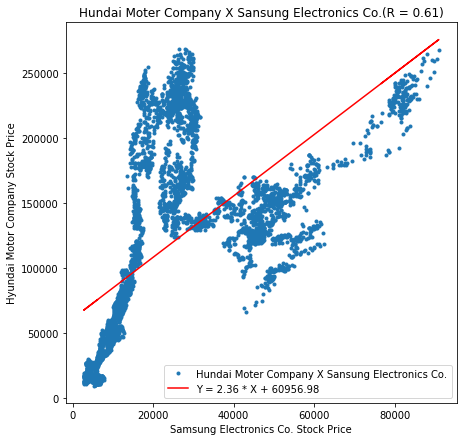

In [294]:
from scipy import stats

df_HMG_SAM = pd.DataFrame({'Y': df['HMG Price'], 'X': df['Samsung Stock Price']})
reg_HMG_SAM = stats.linregress(df_HMG_SAM.X, df_HMG_SAM.Y)
reg_HMG_SAM_line = f'Y = {reg_HMG_SAM.slope:.2f} * X + {reg_HMG_SAM.intercept:.2f}'

plt.figure(figsize=(7,7))
plt.plot(df_HMG_SAM.X, df_HMG_SAM.Y, '.')
plt.plot(df_HMG_SAM.X, reg_HMG_SAM.slope * df_HMG_SAM.X + reg_HMG_SAM.intercept, 'r')
plt.legend(['Hundai Moter Company X Sansung Electronics Co.', reg_HMG_SAM_line])
plt.title(f'Hundai Moter Company X Sansung Electronics Co.(R = {reg_HMG_SAM.rvalue:.2f})')
plt.ylabel('Hyundai Motor Company Stock Price')
plt.xlabel('Samsung Electronics Co. Stock Price')
plt.show()

In [295]:
reg_HMG_SAM

LinregressResult(slope=2.36038267346822, intercept=60956.976875434455, rvalue=0.6097856357054325, pvalue=0.0, stderr=0.0406924504813802)

In [296]:
# 결정계수(R squared)
df['Samsung Stock Price'].corr(df['HMG Price']) ** 2

0.3718385215126783

##### **현대자동차 주가와 기아자동차 주가와의 상관관계**

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


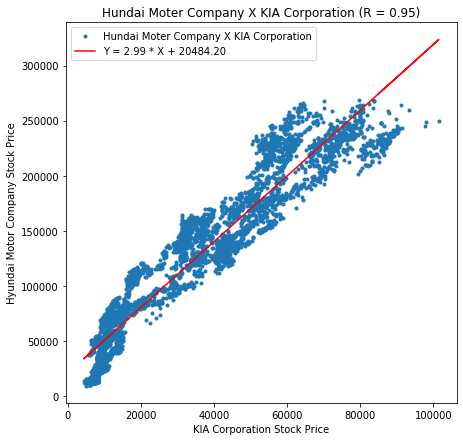

In [297]:
df_HMG_KIA = pd.DataFrame({'Y': df['HMG Price'], 'X': df['KIA Stock Price']})
reg_HMG_KIA = stats.linregress(df_HMG_KIA.X, df_HMG_KIA.Y)
reg_HMG_KIA_line = f'Y = {reg_HMG_KIA.slope:.2f} * X + {reg_HMG_KIA.intercept:.2f}'

plt.figure(figsize=(7,7))
plt.plot(df_HMG_KIA.X, df_HMG_KIA.Y, '.')
plt.plot(df_HMG_KIA.X, reg_HMG_KIA.slope * df_HMG_KIA.X + reg_HMG_KIA.intercept, 'r')
plt.legend(['Hundai Moter Company X KIA Corporation', reg_HMG_KIA_line])
plt.title(f'Hundai Moter Company X KIA Corporation (R = {reg_HMG_KIA.rvalue:.2f})')
plt.ylabel('Hyundai Motor Company Stock Price')
plt.xlabel('KIA Corporation Stock Price')
plt.show()

In [298]:
reg_HMG_KIA

LinregressResult(slope=2.986006354326635, intercept=20484.198839064877, rvalue=0.9535224186225447, pvalue=0.0, stderr=0.012515947833682267)

In [299]:
# 결정계수(R squared)
df['KIA Stock Price'].corr(df['HMG Price']) ** 2

0.9092050028157874

##### **소결론**
1. 가설1은 양의 상관관계를 보이는 것을 알 수 있다.
2. 삼성전자와의 R2점수는 0.37, 기아자동차와의 R2점수는 0.95이다.
3. 기아자동차와의 회귀선은 변수사이의 관계를 잘 설명한다고 볼 수 있다.

#### **가설2(현대자동차의 주가와 환율과의 상관관계) 검정**

##### **현대자동차 주가와 USD환율과의 상관관계**

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


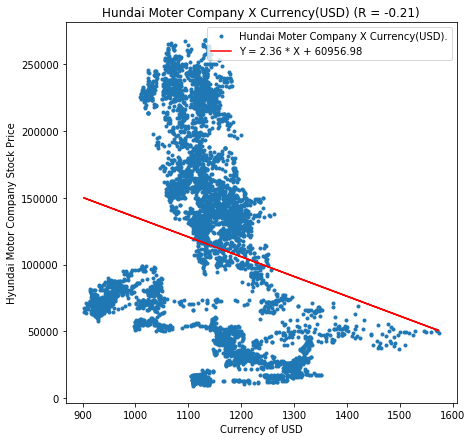

In [300]:
df_HMG_USD = pd.DataFrame({'Y': df['HMG Price'], 'X': df['USD']})
reg_HMG_USD = stats.linregress(df_HMG_USD.X, df_HMG_USD.Y)
reg_HMG_USD_line = f'Y = {reg_HMG_USD.slope:.2f} * X + {reg_HMG_USD.intercept:.2f}'

plt.figure(figsize=(7,7))
plt.plot(df_HMG_USD.X, df_HMG_USD.Y, '.')
plt.plot(df_HMG_USD.X, reg_HMG_USD.slope * df_HMG_USD.X + reg_HMG_USD.intercept, 'r')
plt.legend(['Hundai Moter Company X Currency(USD).', reg_HMG_SAM_line])
plt.title(f'Hundai Moter Company X Currency(USD) (R = {reg_HMG_USD.rvalue:.2f})')
plt.ylabel('Hyundai Motor Company Stock Price')
plt.xlabel('Currency of USD')
plt.show()

In [301]:
reg_HMG_USD

LinregressResult(slope=-148.0974937206438, intercept=283583.4477168745, rvalue=-0.20680396052466962, pvalue=5.733315897620264e-56, stderr=9.29331064662388)

In [302]:
# 결정계수(R squared)
df['USD'].corr(df['HMG Price']) ** 2

0.042767878088689135

##### **현대자동차 주가와 중국위안화 환율과의 상관관계**

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


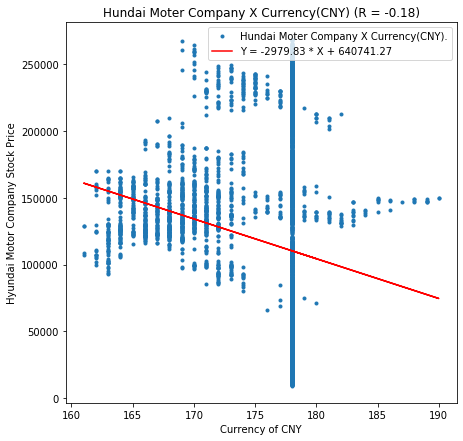

In [303]:
df_HMG_CNY = pd.DataFrame({'Y': df['HMG Price'], 'X': df['CNY']})
reg_HMG_CNY = stats.linregress(df_HMG_CNY.X, df_HMG_CNY.Y)
reg_HMG_CNY_line = f'Y = {reg_HMG_CNY.slope:.2f} * X + {reg_HMG_CNY.intercept:.2f}'

plt.figure(figsize=(7,7))
plt.plot(df_HMG_CNY.X, df_HMG_CNY.Y, '.')
plt.plot(df_HMG_CNY.X, reg_HMG_CNY.slope * df_HMG_CNY.X + reg_HMG_CNY.intercept, 'r')
plt.legend(['Hundai Moter Company X Currency(CNY).', reg_HMG_CNY_line])
plt.title(f'Hundai Moter Company X Currency(CNY) (R = {reg_HMG_CNY.rvalue:.2f})')
plt.ylabel('Hyundai Motor Company Stock Price')
plt.xlabel('Currency of CNY')
plt.show()

In [304]:
reg_HMG_USD

LinregressResult(slope=-148.0974937206438, intercept=283583.4477168745, rvalue=-0.20680396052466962, pvalue=5.733315897620264e-56, stderr=9.29331064662388)

In [305]:
# 결정계수(R squared)
df['CNY'].corr(df['HMG Price']) ** 2

0.03153983156099891

##### **현대자동차 주가와 일본엔화 환율과의 상관관계**

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


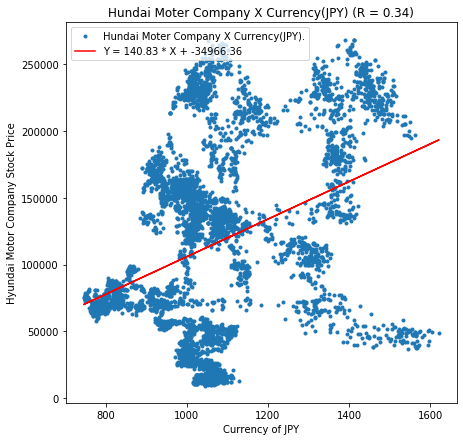

In [306]:
df_HMG_JPY = pd.DataFrame({'Y': df['HMG Price'], 'X': df['JPY']})
reg_HMG_JPY = stats.linregress(df_HMG_JPY.X, df_HMG_JPY.Y)
reg_HMG_JPY_line = f'Y = {reg_HMG_JPY.slope:.2f} * X + {reg_HMG_JPY.intercept:.2f}'

plt.figure(figsize=(7,7))
plt.plot(df_HMG_JPY.X, df_HMG_JPY.Y, '.')
plt.plot(df_HMG_JPY.X, reg_HMG_JPY.slope * df_HMG_JPY.X + reg_HMG_JPY.intercept, 'r')
plt.legend(['Hundai Moter Company X Currency(JPY).', reg_HMG_JPY_line])
plt.title(f'Hundai Moter Company X Currency(JPY) (R = {reg_HMG_JPY.rvalue:.2f})')
plt.ylabel('Hyundai Motor Company Stock Price')
plt.xlabel('Currency of JPY')
plt.show()

In [307]:
reg_HMG_JPY

LinregressResult(slope=140.82625120166603, intercept=-34966.36090896302, rvalue=0.34079752421095594, pvalue=1.2860119539322357e-154, stderr=5.152893509591538)

In [308]:
# 결정계수(R squared)
df['JPY'].corr(df['HMG Price']) ** 2

0.11614295250831717

##### **현대자동차 주가와 유로화 환율과의 상관관계**

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


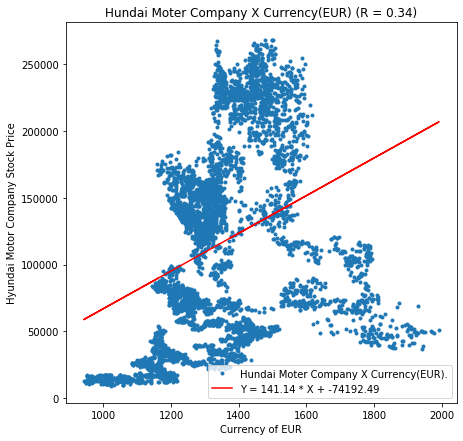

In [309]:
df_HMG_EUR = pd.DataFrame({'Y': df['HMG Price'], 'X': df['EUR']})
reg_HMG_EUR = stats.linregress(df_HMG_EUR.X, df_HMG_EUR.Y)
reg_HMG_EUR_line = f'Y = {reg_HMG_EUR.slope:.2f} * X + {reg_HMG_EUR.intercept:.2f}'

plt.figure(figsize=(7,7))
plt.plot(df_HMG_EUR.X, df_HMG_EUR.Y, '.')
plt.plot(df_HMG_EUR.X, reg_HMG_EUR.slope * df_HMG_EUR.X + reg_HMG_EUR.intercept, 'r')
plt.legend(['Hundai Moter Company X Currency(EUR).', reg_HMG_EUR_line])
plt.title(f'Hundai Moter Company X Currency(EUR) (R = {reg_HMG_EUR.rvalue:.2f})')
plt.ylabel('Hyundai Motor Company Stock Price')
plt.xlabel('Currency of EUR')
plt.show()

In [310]:
reg_HMG_EUR

LinregressResult(slope=141.14393526989625, intercept=-74192.48893542701, rvalue=0.3350827487261939, pvalue=3.152254164915662e-149, stderr=5.26406217871535)

In [311]:
# 결정계수(R squared)
df['EUR'].corr(df['HMG Price']) ** 2

0.11228044849390165

##### **현대자동차 주가와 영국파운드화 환율과의 상관관계**

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


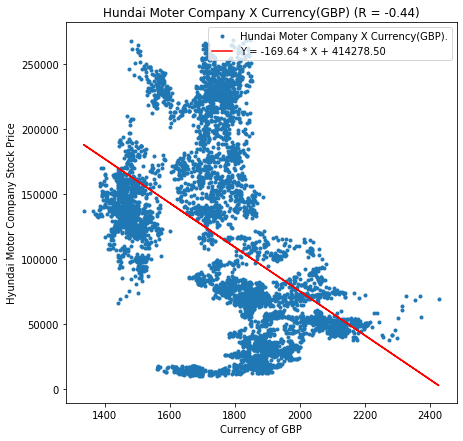

In [312]:
df_HMG_GBP = pd.DataFrame({'Y': df['HMG Price'], 'X': df['GBP']})
reg_HMG_GBP = stats.linregress(df_HMG_GBP.X, df_HMG_GBP.Y)
reg_HMG_GBP_line = f'Y = {reg_HMG_GBP.slope:.2f} * X + {reg_HMG_GBP.intercept:.2f}'

plt.figure(figsize=(7,7))
plt.plot(df_HMG_GBP.X, df_HMG_GBP.Y, '.')
plt.plot(df_HMG_GBP.X, reg_HMG_GBP.slope * df_HMG_GBP.X + reg_HMG_GBP.intercept, 'r')
plt.legend(['Hundai Moter Company X Currency(GBP).', reg_HMG_GBP_line])
plt.title(f'Hundai Moter Company X Currency(GBP) (R = {reg_HMG_GBP.rvalue:.2f})')
plt.ylabel('Hyundai Motor Company Stock Price')
plt.xlabel('Currency of GBP')
plt.show()

In [313]:
reg_HMG_GBP

LinregressResult(slope=-169.6443972728618, intercept=414278.4961476476, rvalue=-0.44402981018225124, pvalue=2.1315467916011113e-273, stderr=4.540609894517557)

In [314]:
# 결정계수(R squared)
df['GBP'].corr(df['HMG Price']) ** 2

0.19716247233048617

##### **소결론**
1. 현대자동차 주가는 유로화와 일본엔화에 대해서는 양의 상관관계를 보였으나, 달러화, 중국위안화, 파운드화에 대해서는 음의 상관관계를 가진다.
2. 하지만 모든 환율에 대해서 결정계수(R2)는 0과 근사한 수치를 보이기 때문에 관계성을 설명하지 못하는 것으로 볼 수 있다.

#### **가설3(현대자동차의 주가와 원자재 가격과의 상관관계) 검정**

##### **현대자동차 주가와 원유가격의 상관관계**

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


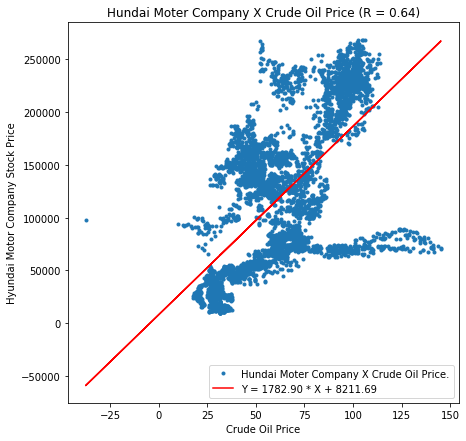

In [315]:
df_HMG_OIL = pd.DataFrame({'Y': df['HMG Price'], 'X': df['Oil Price']})
reg_HMG_OIL = stats.linregress(df_HMG_OIL.X, df_HMG_OIL.Y)
reg_HMG_OIL_line = f'Y = {reg_HMG_OIL.slope:.2f} * X + {reg_HMG_OIL.intercept:.2f}'

plt.figure(figsize=(7,7))
plt.plot(df_HMG_OIL.X, df_HMG_OIL.Y, '.')
plt.plot(df_HMG_OIL.X, reg_HMG_OIL.slope * df_HMG_OIL.X + reg_HMG_OIL.intercept, 'r')
plt.legend(['Hundai Moter Company X Crude Oil Price.', reg_HMG_OIL_line])
plt.title(f'Hundai Moter Company X Crude Oil Price (R = {reg_HMG_OIL.rvalue:.2f})')
plt.ylabel('Hyundai Motor Company Stock Price')
plt.xlabel('Crude Oil Price')
plt.show()

In [316]:
reg_HMG_OIL

LinregressResult(slope=1782.9010355219932, intercept=8211.69286154324, rvalue=0.6399732735444774, pvalue=0.0, stderr=28.393839377323715)

In [317]:
# 결정계수(R squared)
df['Oil Price'].corr(df['HMG Price']) ** 2

0.4095657908512345

##### **현대자동차 주가와 금가격과의 상관관계**

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


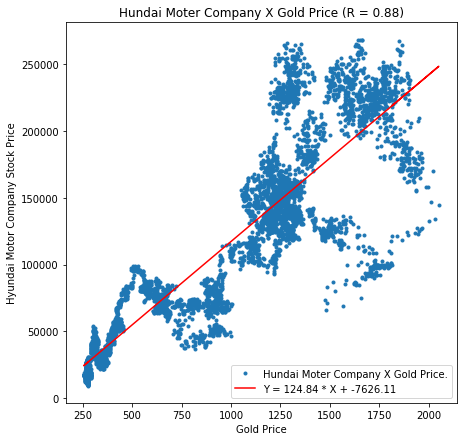

In [318]:
df_HMG_GOLD = pd.DataFrame({'Y': df['HMG Price'], 'X': df['Gold Price']})
reg_HMG_GOLD = stats.linregress(df_HMG_GOLD.X, df_HMG_GOLD.Y)
reg_HMG_GOLD_line = f'Y = {reg_HMG_GOLD.slope:.2f} * X + {reg_HMG_GOLD.intercept:.2f}'

plt.figure(figsize=(7,7))
plt.plot(df_HMG_GOLD.X, df_HMG_GOLD.Y, '.')
plt.plot(df_HMG_GOLD.X, reg_HMG_GOLD.slope * df_HMG_GOLD.X + reg_HMG_GOLD.intercept, 'r')
plt.legend(['Hundai Moter Company X Gold Price.', reg_HMG_GOLD_line])
plt.title(f'Hundai Moter Company X Gold Price (R = {reg_HMG_GOLD.rvalue:.2f})')
plt.ylabel('Hyundai Motor Company Stock Price')
plt.xlabel('Gold Price')
plt.show()

In [319]:
reg_HMG_GOLD

LinregressResult(slope=124.84092340853559, intercept=-7626.1053789474245, rvalue=0.8776020235469049, pvalue=0.0, stderr=0.9045263293822363)

In [320]:
# 결정계수(R squared)
df['Gold Price'].corr(df['HMG Price']) ** 2

0.7701853117336221

##### **소결론**
1. 현대자동차 주가와 원자재값은 양의 상관관계를 가지는 것으로 볼 수 있다.
2. 결정계수(R2)는 원유 가격(0.41), 금 가격(0.77)이다.
3. 현대자동차 주가는 금값과의 관계를 어느정도 잘 설명한다고 볼 수 있다.

#### **가설4(현대자동차의 주가와 주가지수와의 상관관계) 검정**

##### **현대자동차와 한국 KOSPI 지수와의 상관관계**

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


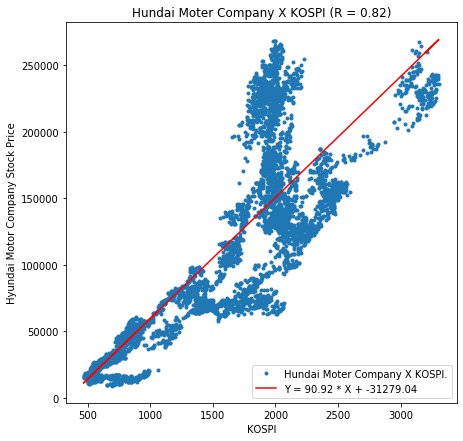

In [321]:
df_HMG_KOSPI = pd.DataFrame({'Y': df['HMG Price'], 'X': df['KOSPI']})
reg_HMG_KOSPI = stats.linregress(df_HMG_KOSPI.X, df_HMG_KOSPI.Y)
reg_HMG_KOSPI_line = f'Y = {reg_HMG_KOSPI.slope:.2f} * X + {reg_HMG_KOSPI.intercept:.2f}'

plt.figure(figsize=(7,7))
plt.plot(df_HMG_KOSPI.X, df_HMG_KOSPI.Y, '.')
plt.plot(df_HMG_KOSPI.X, reg_HMG_KOSPI.slope * df_HMG_KOSPI.X + reg_HMG_KOSPI.intercept, 'r')
plt.legend(['Hundai Moter Company X KOSPI.', reg_HMG_KOSPI_line])
plt.title(f'Hundai Moter Company X KOSPI (R = {reg_HMG_KOSPI.rvalue:.2f})')
plt.ylabel('Hyundai Motor Company Stock Price')
plt.xlabel('KOSPI')
plt.show()

In [322]:
reg_HMG_KOSPI

LinregressResult(slope=90.92097544023528, intercept=-31279.042981330684, rvalue=0.8160240373725001, pvalue=0.0, stderr=0.8542312170534134)

In [323]:
# 결정계수(R squared)
df['KOSPI'].corr(df['HMG Price']) ** 2

0.6658952295697156

##### **현대자동차와 미국 다우존스 산업평균지수와의 상관관계**

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


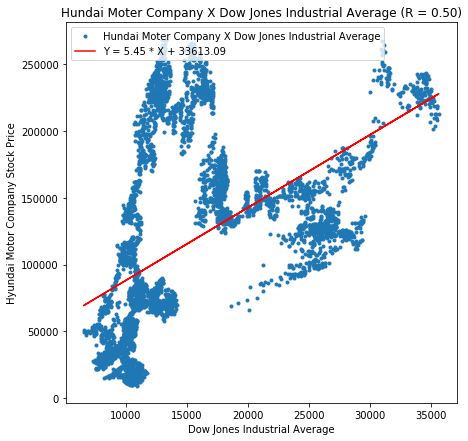

In [324]:
df_HMG_DJI = pd.DataFrame({'Y': df['HMG Price'], 'X': df['DJI']})
reg_HMG_DJI = stats.linregress(df_HMG_DJI.X, df_HMG_DJI.Y)
reg_HMG_DJI_line = f'Y = {reg_HMG_DJI.slope:.2f} * X + {reg_HMG_DJI.intercept:.2f}'

plt.figure(figsize=(7,7))
plt.plot(df_HMG_DJI.X, df_HMG_DJI.Y, '.')
plt.plot(df_HMG_DJI.X, reg_HMG_DJI.slope * df_HMG_DJI.X + reg_HMG_DJI.intercept, 'r')
plt.legend(['Hundai Moter Company X Dow Jones Industrial Average', reg_HMG_DJI_line])
plt.title(f'Hundai Moter Company X Dow Jones Industrial Average (R = {reg_HMG_DJI.rvalue:.2f})')
plt.ylabel('Hyundai Motor Company Stock Price')
plt.xlabel('Dow Jones Industrial Average')
plt.show()

In [325]:
reg_HMG_DJI

LinregressResult(slope=5.453408498524737, intercept=33613.09397621188, rvalue=0.4981377531228594, pvalue=0.0, stderr=0.1259098411392072)

In [326]:
# 결정계수(R squared)
df['DJI'].corr(df['HMG Price']) ** 2

0.2481412210862909

##### **현대자동차와 미국 S&P500 지수와의 상관관계**

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


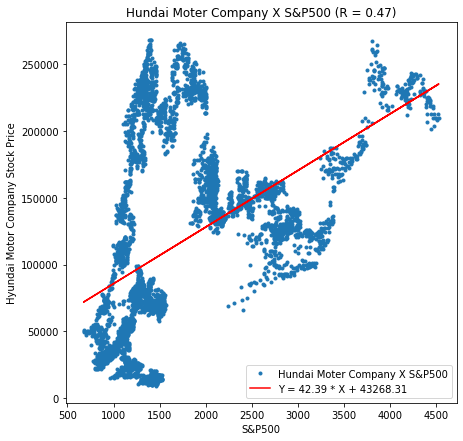

In [327]:
df_HMG_SP = pd.DataFrame({'Y': df['HMG Price'], 'X': df['S&P500']})
reg_HMG_SP = stats.linregress(df_HMG_SP.X, df_HMG_SP.Y)
reg_HMG_SP_line = f'Y = {reg_HMG_SP.slope:.2f} * X + {reg_HMG_SP.intercept:.2f}'

plt.figure(figsize=(7,7))
plt.plot(df_HMG_SP.X, df_HMG_SP.Y, '.')
plt.plot(df_HMG_SP.X, reg_HMG_SP.slope * df_HMG_SP.X + reg_HMG_SP.intercept, 'r')
plt.legend(['Hundai Moter Company X S&P500', reg_HMG_SP_line])
plt.title(f'Hundai Moter Company X S&P500 (R = {reg_HMG_SP.rvalue:.2f})')
plt.ylabel('Hyundai Motor Company Stock Price')
plt.xlabel('S&P500')
plt.show()

In [328]:
reg_HMG_SP

LinregressResult(slope=42.390413479788535, intercept=43268.31008553438, rvalue=0.465375771835104, pvalue=1.2526096792917091e-303, stderr=1.069388895539774)

In [329]:
# 결정계수(R squared)
df['S&P500'].corr(df['HMG Price']) ** 2

0.21657460901111875

##### **현대자동차와 미국 나스닥 지수와의 상관관계**

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


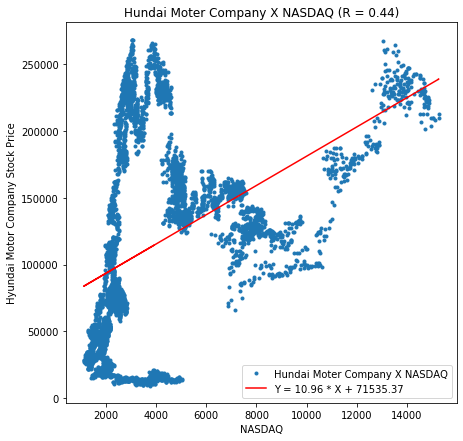

In [330]:
df_HMG_NAS = pd.DataFrame({'Y': df['HMG Price'], 'X': df['NASDAQ']})
reg_HMG_NAS = stats.linregress(df_HMG_NAS.X, df_HMG_NAS.Y)
reg_HMG_NAS_line = f'Y = {reg_HMG_NAS.slope:.2f} * X + {reg_HMG_NAS.intercept:.2f}'

plt.figure(figsize=(7,7))
plt.plot(df_HMG_NAS.X, df_HMG_NAS.Y, '.')
plt.plot(df_HMG_NAS.X, reg_HMG_NAS.slope * df_HMG_NAS.X + reg_HMG_NAS.intercept, 'r')
plt.legend(['Hundai Moter Company X NASDAQ', reg_HMG_NAS_line])
plt.title(f'Hundai Moter Company X NASDAQ (R = {reg_HMG_NAS.rvalue:.2f})')
plt.ylabel('Hyundai Motor Company Stock Price')
plt.xlabel('NASDAQ')
plt.show()

In [331]:
reg_HMG_NAS

LinregressResult(slope=10.96432070136169, intercept=71535.37049325675, rvalue=0.4436087440135542, pvalue=8.008931529752251e-273, stderr=0.29381197832155187)

In [332]:
# 결정계수(R squared)
df['NASDAQ'].corr(df['HMG Price']) ** 2

0.19678871776528317

##### **현대자동차와 일본 닛케이 225 지수와의 상관관계**

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


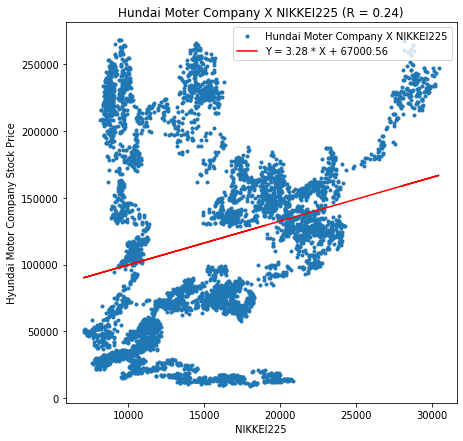

In [333]:
df_HMG_NIKKEI = pd.DataFrame({'Y': df['HMG Price'], 'X': df['NIKKEI 225']})
reg_HMG_NIKKEI = stats.linregress(df_HMG_NIKKEI.X, df_HMG_NIKKEI.Y)
reg_HMG_NIKKEI_line = f'Y = {reg_HMG_NIKKEI.slope:.2f} * X + {reg_HMG_NIKKEI.intercept:.2f}'

plt.figure(figsize=(7,7))
plt.plot(df_HMG_NIKKEI.X, df_HMG_NIKKEI.Y, '.')
plt.plot(df_HMG_NIKKEI.X, reg_HMG_NIKKEI.slope * df_HMG_NIKKEI.X + reg_HMG_NIKKEI.intercept, 'r')
plt.legend(['Hundai Moter Company X NIKKEI225', reg_HMG_NIKKEI_line])
plt.title(f'Hundai Moter Company X NIKKEI225 (R = {reg_HMG_NIKKEI.rvalue:.2f})')
plt.ylabel('Hyundai Motor Company Stock Price')
plt.xlabel('NIKKEI225')
plt.show()

In [334]:
reg_HMG_NIKKEI

LinregressResult(slope=3.2762739761977357, intercept=67000.56088637737, rvalue=0.23813344792906738, pvalue=3.903706221948173e-74, stderr=0.17723764023322888)

In [335]:
# 결정계수(R squared)
df['NIKKEI 225'].corr(df['HMG Price']) ** 2

0.056707539022585844

##### **현대자동차와 독일 DAX50 지수와의 상관관계**

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


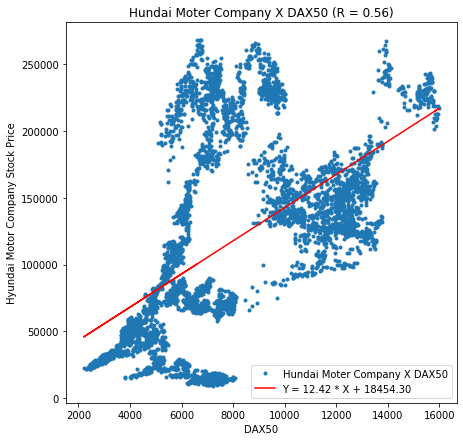

In [336]:
df_HMG_DAX  = pd.DataFrame({'Y': df['HMG Price'], 'X': df['DAX50']})
reg_HMG_DAX = stats.linregress(df_HMG_DAX.X, df_HMG_DAX.Y)
reg_HMG_DAX_line = f'Y = {reg_HMG_DAX.slope:.2f} * X + {reg_HMG_DAX.intercept:.2f}'

plt.figure(figsize=(7,7))
plt.plot(df_HMG_DAX.X, df_HMG_DAX.Y, '.')
plt.plot(df_HMG_DAX.X, reg_HMG_DAX.slope * df_HMG_DAX.X + reg_HMG_DAX.intercept, 'r')
plt.legend(['Hundai Moter Company X DAX50', reg_HMG_DAX_line])
plt.title(f'Hundai Moter Company X DAX50 (R = {reg_HMG_DAX.rvalue:.2f})')
plt.ylabel('Hyundai Motor Company Stock Price')
plt.xlabel('DAX50')
plt.show()

In [337]:
reg_HMG_DAX

LinregressResult(slope=12.416617735478926, intercept=18454.301494313797, rvalue=0.5567300713330589, pvalue=0.0, stderr=0.24573803917637918)

In [338]:
# 결정계수(R squared)
df['DAX50'].corr(df['HMG Price']) ** 2

0.3099483723265128

##### **현대자동차와 프랑스 CAC40 지수와의 상관관계**

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


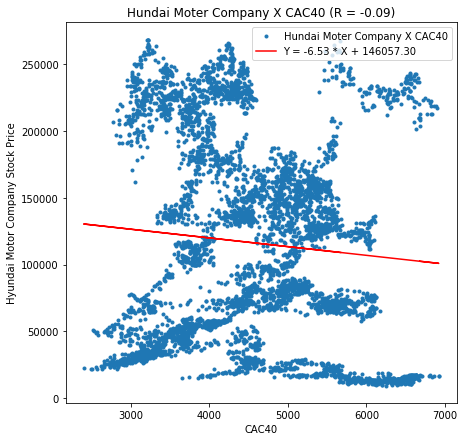

In [339]:
df_HMG_CAC = pd.DataFrame({'Y': df['HMG Price'], 'X': df['CAC40']})
reg_HMG_CAC = stats.linregress(df_HMG_CAC.X, df_HMG_CAC.Y)
reg_HMG_CAC_line = f'Y = {reg_HMG_CAC.slope:.2f} * X + {reg_HMG_CAC.intercept:.2f}'

plt.figure(figsize=(7,7))
plt.plot(df_HMG_CAC.X, df_HMG_CAC.Y, '.')
plt.plot(df_HMG_CAC.X, reg_HMG_CAC.slope * df_HMG_CAC.X + reg_HMG_CAC.intercept, 'r')
plt.legend(['Hundai Moter Company X CAC40', reg_HMG_CAC_line])
plt.title(f'Hundai Moter Company X CAC40 (R = {reg_HMG_CAC.rvalue:.2f})')
plt.ylabel('Hyundai Motor Company Stock Price')
plt.xlabel('CAC40')
plt.show()

In [340]:
reg_HMG_CAC

LinregressResult(slope=-6.525924518937185, intercept=146057.30201645166, rvalue=-0.08805566837822304, pvalue=2.9041514574770648e-11, stderr=0.979191006032028)

In [341]:
# 결정계수(R squared)
df['CAC40'].corr(df['HMG Price']) ** 2

0.007753800733535589

##### **소결론**
1. 현대자동차 주가와 KOSPI, 다우존스산업평균, S&P500, 나스닥, 닛케이, DAX지수와는 양의 상관관계를 가지는 것을 알 수 있다. 반면, CAC40지수는 음의 상관관계를 갖는다.
2. 결정계수(R2)는 KOSPI(0.67), DAX50(0.31), 다우존스산업평균(0.25), S&P500(0.22), 나스닥(0.20), 닛케이(0.06), CAC40(0.01)이다.
3. 현대자동차 주가는 코스피 지수와의 회귀선이 관계를 잘 설명하는 것으로 볼 수 있으며, 타 지수와의 관계는 설명하기 다소 어렵다.

#### **중결론**
1. 현대자동차의 주가는 기아자동차의 주가와 양의 상관관계가 있다.
2. 현대자동차의 주가는 유가와 양의 상관관계가 있다.
3. 현대자동차의 주가는 코스피 지수와 양의 상관관계가 있다.

## **가설**
특성을 통해 현대자동차 주가의 상승여부를 예측할 수 있다.

## **전일 대비 등락율 계산**

In [342]:
df_rate = df

for date in df_rate.columns[::-1]:
    df_rate[date] = round((df_rate[date]-df_rate[date].shift(1)) / df_rate[date].shift(1) * 100, 0)
      
df_rate.iloc[0] = 1

df_rate

,HMG Price,HMG Volume,Samsung Stock Price,KIA Stock Price,USD,CNY,JPY,EUR,GBP,Gold Price,Oil Price,KOSPI,DJI,S&P500,NASDAQ,NIKKEI 225,DAX50,CAC40
Date,,,,,,,,,,,,,,,,,,
2000-01-04,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2000-01-05,0.0,102.0,-9.0,-5.0,-1.0,0.0,-2.0,-0.0,-1.0,0.0,0.0,-7.0,1.0,0.0,-1.0,-2.0,-1.0,-3.0
2000-01-06,-5.0,-54.0,1.0,-4.0,0.0,0.0,-0.0,1.0,1.0,0.0,0.0,-3.0,1.0,0.0,-4.0,-2.0,-0.0,-1.0
2000-01-07,3.0,16.0,-1.0,-2.0,1.0,0.0,-0.0,1.0,1.0,0.0,0.0,-1.0,2.0,3.0,4.0,0.0,5.0,2.0
2000-01-08,-1.0,-12.0,4.0,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,4.0,4.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-25,0.0,-36.0,0.0,0.0,-1.0,-1.0,-0.0,-0.0,-0.0,-1.0,1.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
2021-08-26,0.0,-13.0,-1.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-0.0,-0.0
2021-08-27,-1.0,20.0,-0.0,0.0,0.0,1.0,0.0,0.0,-0.0,1.0,2.0,0.0,1.0,1.0,1.0,-0.0,0.0,0.0


In [343]:
df_prob = df_rate

for col in df_prob[::-1]:
    df_prob.loc[df_prob[col] >= 0, col] = 1
    df_prob.loc[df_prob[col] < 0, col] = 0

df_prob

,HMG Price,HMG Volume,Samsung Stock Price,KIA Stock Price,USD,CNY,JPY,EUR,GBP,Gold Price,Oil Price,KOSPI,DJI,S&P500,NASDAQ,NIKKEI 225,DAX50,CAC40
Date,,,,,,,,,,,,,,,,,,
2000-01-04,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2000-01-05,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2000-01-06,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2000-01-07,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2000-01-08,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-25,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-08-26,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2021-08-27,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [344]:
df = df_prob

### **EDA, Feature Engineering 방향**
- 각 항목별 등락여부를 새로 생성함으로써 특성의 등락 여부에 따른 타겟의 등락 여부 예측

## **데이터 분리**

In [345]:
# 타겟 데이터 선정
target = 'HMG Price'

In [346]:
# 2019-01-02훈련/테스트 데이터 분리
Cutoff_test = pd.to_datetime('2019-01-01')
train = df[df.index < Cutoff_test]
test = df[df.index >= Cutoff_test]

train.shape, test.shape

((4993, 18), (693, 18))

In [347]:
# 2015-01-02 기준 훈련/검정 데이터 분리
Cutoff_val = pd.to_datetime('2016-01-01')
val = train[train.index >= Cutoff_val]
train = train[train.index < Cutoff_val]

train.shape, val.shape

((4212, 18), (781, 18))

# **EDA, Preprocessing**

# **베이스라인 선택**

In [348]:
# 타겟 비율 확인
## 0: 전일 대비 주가 하락
## 1: 전일 대비 주가 변동 없음
## 2: 전일 대비 주가 상승
y_train = train[target]
y_train.value_counts(normalize=True)

1.0    0.633428
0.0    0.366572
Name: HMG Price, dtype: float64

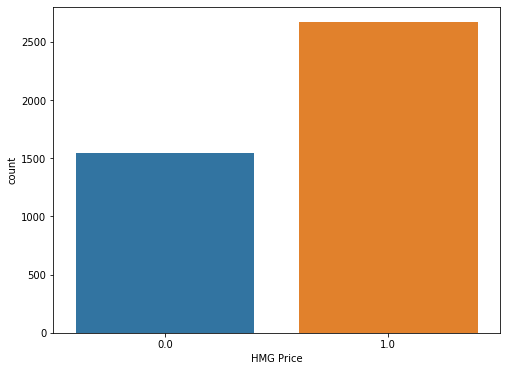

In [349]:
import seaborn as sns
sns.countplot(x=y_train);

## **문제정의**
- 현대자동차의 주가 변동여부는 클래스가 2개(0, 1)인 분류 문제
- 가장 큰 범주(1)가 63.3%를 차지하고 있는 불균형 분류 문제


In [350]:
# 평가지표 확인
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
# 예측 수행
major = y_train.mode()[0]
y_pred = [major] * len(y_train)
# 훈련세트 평가
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1544
         1.0       0.63      1.00      0.78      2668

    accuracy                           0.63      4212
   macro avg       0.32      0.50      0.39      4212
weighted avg       0.40      0.63      0.49      4212



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [351]:
# 검증세트 평가
y_val = val[target]
y_pred = [major] * len(y_val)
print('<검증 정확도> \n', accuracy_score(y_val, y_pred))
print('<classification_report> \n', classification_report(y_val, y_pred))
print('<검증 f1 score>', f1_score(y_val,y_pred))

<검증 정확도> 
 0.647887323943662
<classification_report> 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       275
         1.0       0.65      1.00      0.79       506

    accuracy                           0.65       781
   macro avg       0.32      0.50      0.39       781
weighted avg       0.42      0.65      0.51       781

<검증 f1 score> 0.7863247863247863


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## **평가지표**

* 기준모델과의 비교는 **정확도**를 비교하고
* 모델간 비교는 성능을 평가하기 위해 **AUC Score**로 비교

# **머신러닝 학습 및 검증**

## **랜덤포레스트 모델**

In [352]:
X_train = train.drop([target], axis=1)
y_train = train[target] 
X_val = val.drop([target], axis=1)
y_val = val[target]
X_test = test.drop([target], axis=1)
y_test = test[target]

In [353]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, validation_curve

In [354]:
pipe_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1, oob_score=True, n_estimators=150, min_samples_split=6)
)

pipe_rf.fit(X_train, y_train)
print('\n훈련정확도: ', pipe_rf.score(X_train, y_train))
print('검증정확도: ', pipe_rf.score(X_val, y_val))

y_pred = pipe_rf.predict(X_val)
print('<검증 정확도> \n', accuracy_score(y_val, y_pred))
print('<classification_report> \n', classification_report(y_val, y_pred))
print('<검증 f1 score>', f1_score(y_pred, y_val))


훈련정확도:  0.8544634377967711
검증정확도:  0.7490396927016645
<검증 정확도> 
 0.7490396927016645
<classification_report> 
               precision    recall  f1-score   support

         0.0       0.69      0.53      0.60       275
         1.0       0.77      0.87      0.82       506

    accuracy                           0.75       781
   macro avg       0.73      0.70      0.71       781
weighted avg       0.74      0.75      0.74       781

<검증 f1 score> 0.8175046554934823


In [355]:
parameters = {   
    'randomforestclassifier__max_depth': range(1, 20, 2), 
    'randomforestclassifier__max_features': range(1, 20, 2), 
    'randomforestclassifier__min_samples_leaf' : range(1, 20, 2)
}

rf_classifier = RandomizedSearchCV(
    pipe_rf, 
    param_distributions=parameters, 
    n_iter=10, 
    cv=5,
    scoring='f1',
    verbose=1,
)

rf_classifier.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Estimator fit failed. The 

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=[],
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=[],
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,
    

In [356]:
# RandomCV 결과 확인
print('Best Parameters: ', rf_classifier.best_params_)
print('f1 score: ', rf_classifier.best_score_)

Best Parameters:  {'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': 3, 'randomforestclassifier__max_depth': 3}
f1 score:  0.8195734999074572


In [357]:
best_pipe_rf = rf_classifier.best_estimator_

y_pred = best_pipe_rf.predict(X_val)
print('<검증 정확도> \n', accuracy_score(y_val, y_pred))
print('<classification_report> \n', classification_report(y_val, y_pred))
print('<검증 f1 score>', f1_score(y_pred, y_val))

<검증 정확도> 
 0.6952624839948783
<classification_report> 
               precision    recall  f1-score   support

         0.0       0.70      0.23      0.35       275
         1.0       0.69      0.95      0.80       506

    accuracy                           0.70       781
   macro avg       0.70      0.59      0.58       781
weighted avg       0.70      0.70      0.64       781

<검증 f1 score> 0.8010033444816054


In [358]:
from sklearn.metrics import roc_auc_score, roc_curve

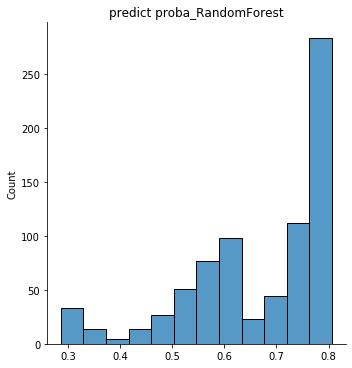

In [359]:
y_pred_proba_rf = best_pipe_rf.predict_proba(X_val)[:, 1]
sns.displot(y_pred_proba_rf)
plt.title('predict proba_RandomForest')
plt.show()

0.7643011139058571

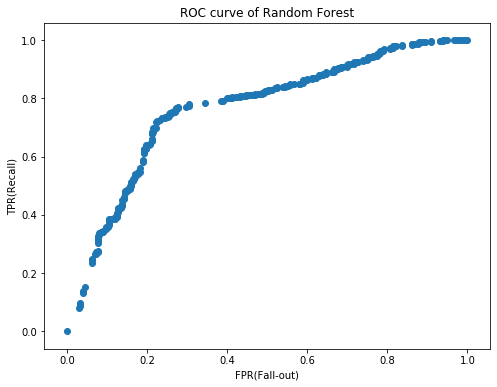

In [360]:
auc_score_rf = roc_auc_score(y_val, y_pred_proba_rf)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, y_pred_proba_rf)

roc = pd.DataFrame({'FPR(Fall_out)': fpr_rf,
                    'TPRate(Recall)': tpr_rf,
                    'Threshold': thresholds_rf})

plt.scatter(fpr_rf, tpr_rf)
plt.title('ROC curve of Random Forest')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')

auc_score_rf

## **XGB Classifier**

In [361]:
from xgboost import XGBClassifier

In [362]:
y_train.value_counts(normalize=True)

1.0    0.633428
0.0    0.366572
Name: HMG Price, dtype: float64

In [363]:
ratio = 0.44 / 0.56
ratio

0.7857142857142857

In [364]:
processor = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train),
            (X_val_processed, y_val)]

xgb = XGBClassifier(n_estimators=1000, verbosity=0, n_jobs=-1, scale_pos_weight=ratio)
xgb.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric ='auc', early_stopping_rounds=10)

[0]	validation_0-auc:0.814717	validation_1-auc:0.780596
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.814717	validation_1-auc:0.780596
[2]	validation_0-auc:0.814717	validation_1-auc:0.780596
[3]	validation_0-auc:0.814717	validation_1-auc:0.780596
[4]	validation_0-auc:0.816448	validation_1-auc:0.78124
[5]	validation_0-auc:0.823001	validation_1-auc:0.783299
[6]	validation_0-auc:0.823204	validation_1-auc:0.783777
[7]	validation_0-auc:0.822963	validation_1-auc:0.783475
[8]	validation_0-auc:0.823119	validation_1-auc:0.784129
[9]	validation_0-auc:0.825258	validation_1-auc:0.784114
[10]	validation_0-auc:0.825591	validation_1-auc:0.785667
[11]	validation_0-auc:0.826964	validation_1-auc:0.786062
[12]	validation_0-auc:0.828087	validation_1-auc:0.787269
[13]	validation_0-auc:0.828064	validation_1-auc:0.786989
[14]	validation_0-auc:0.828466	validation_1-auc:0.787409

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.7857142857142857,
              seed=None, silent=None, subsample=1, verbosity=0)

In [388]:
print('\n훈련정확도: ', xgb.score(X_train_processed, y_train))
print('검증정확도: ', xgb.score(X_val_processed, y_val))

y_pred = xgb.predict(X_val_processed)
y_pred_proba = xgb.predict_proba(X_val_processed)[:, class_index]

print('<검증 정확도> \n', accuracy_score(y_val, y_pred))
print('<classification_report> \n', classification_report(y_val, y_pred))
print('<검증 f1 score>', f1_score(y_pred, y_val))
print(roc_auc_score(y_val, y_pred_proba))


훈련정확도:  0.76661918328585
검증정확도:  0.7477592829705506
<검증 정확도> 
 0.7477592829705506
<classification_report> 
               precision    recall  f1-score   support

         0.0       0.63      0.69      0.66       275
         1.0       0.82      0.78      0.80       506

    accuracy                           0.75       781
   macro avg       0.73      0.74      0.73       781
weighted avg       0.76      0.75      0.75       781

<검증 f1 score> 0.7995930824008137
0.787804527488322


In [ ]:
y_pred_proba = xgb.predict_proba(X_test_processed)[:, class_index]
print(f'Test AUC for class "{xgb.classes_[class_index]}":')
print(roc_auc_score(y_test, y_pred_proba))

## **중결론**
- 기준모델 검증 f1 점수: 0.72
- 랜덤포레스트모델 검증 f1 점수: 0.75
- XGBoost모델 검증 f1 점수: 0.76

하이퍼파라미터 튜닝을 통해 최적의 파라미터를 적용했을 때 더 좋은 성능을 보여주는 모델은 XGBoost모델로, 최종 모델로 선정

In [366]:
X_test_processed = processor.transform(X_test)
X_val_processed = processor.transform(X_val)
class_index = 1
y_pred_proba = xgb.predict_proba(X_test_processed)[:, class_index]
print(f'Test AUC for class "{xgb.classes_[class_index]}":')
print(roc_auc_score(y_test, y_pred_proba)) # 범위는 0-1, 수치는 높을 수록 좋습니다

Test AUC for class "1.0":
0.835887390670554


In [367]:
y_test_pred = xgb.predict(X_test_processed)
print(classification_report(y_test, y_test_pred))
print('f1 score: ', f1_score(y_test_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.66      0.75      0.70       245
         1.0       0.85      0.79      0.82       448

    accuracy                           0.78       693
   macro avg       0.76      0.77      0.76       693
weighted avg       0.79      0.78      0.78       693

f1 score:  0.8203939745075319


In [368]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    xgb,
    scoring='accuracy',
    n_iter=5,
)

In [369]:
permuter.fit(X_test_processed, y_test);

feature_names = df.columns.tolist()
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names[1:]
)

Weight,Feature
0.1931 ± 0.0213,KIA Stock Price
0.0058 ± 0.0045,CAC40
0 ± 0.0000,DAX50
0 ± 0.0000,CNY
0 ± 0.0000,JPY
0 ± 0.0000,EUR
0 ± 0.0000,GBP
0 ± 0.0000,Gold Price
0 ± 0.0000,DJI
0 ± 0.0000,S&P500


# **결론**

In [370]:
df_left = pd.DataFrame({
    'pred_proba': y_pred_proba,
    'status_group': y_test
})

df_right = X_test[['KIA Stock Price', 'KOSPI', 'EUR', 'S&P500', 'USD', 'NASDAQ']]

df_merge = pd.merge(df_left, df_right, left_index=True, right_index=True, how='left')

In [371]:
increase = df_merge['status_group'] == 1
decrease = ~increase
right = (increase) == (df_merge['pred_proba'] > 0.50)
wrong = ~right

In [372]:
df_merge[increase & right].sample(n=10).sort_values(by='pred_proba')

,pred_proba,status_group,KIA Stock Price,KOSPI,EUR,S&P500,USD,NASDAQ
Date,,,,,,,,
2019-12-24,0.561723,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2021-05-03,0.602176,1.0,1.0,0.0,0.0,1.0,1.0,1.0
2019-08-19,0.690488,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2019-11-28,0.723813,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2019-06-21,0.767042,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2019-02-25,0.790922,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2019-01-23,0.790922,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2019-10-08,0.810719,1.0,1.0,1.0,1.0,0.0,1.0,0.0
2020-12-03,0.816310,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [389]:
row = pd.DataFrame(X_test.loc['2020-11-11']).T
row

,HMG Volume,Samsung Stock Price,KIA Stock Price,USD,CNY,JPY,EUR,GBP,Gold Price,Oil Price,KOSPI,DJI,S&P500,NASDAQ,NIKKEI 225,DAX50,CAC40
2020-11-11,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [390]:
import xgboost
import shap

explainer = shap.TreeExplainer(xgb)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row,
    link='logit'
)

In [391]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

In [392]:
pros = shaps.sort_values(ascending=False)[:3].index
cons = shaps.sort_values(ascending=True)[:3].index

In [393]:
print('fully paid 예측에 대한 Positive 요인 Top 3 입니다:')
for i, pro in enumerate(pros, start=1):
    feature_name, feature_value = pro
    print(f'{i}. {feature_name} : {feature_value}')

print('\n')
print('Negative 요인 Top 3 입니다:')
for i, con in enumerate(cons, start=1):
    feature_name, feature_value = con
    print(f'{i}. {feature_name} : {feature_value}')

fully paid 예측에 대한 Positive 요인 Top 3 입니다:
1. KIA Stock Price : 1.0
2. KOSPI : 1.0
3. Samsung Stock Price : 1.0


Negative 요인 Top 3 입니다:
1. Gold Price : 0.0
2. NASDAQ : 1.0
3. S&P500 : 1.0


In [378]:
# 예측 함수
def explain(year, month, day):
    positive_class = 1
    date = str(year) + '-' + str(month) + '-' + str(day)
    row = pd.DataFrame(X_test.loc[date]).T
    row_processed = processor.transform(row)

    pred = xgb.predict(row_processed)[0]
    if pred == 1:
        pred_index = '증가'
    else:
        pred_index = '감소'
    pred_proba = xgb.predict_proba(row_processed)[0, positive_class]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba

    print(f'현대자동차 주가의 예측결과는 {pred_index}로, 확률은 {pred_proba:.0f}% 입니다.')

    shap_values = explainer.shap_values(row_processed)

    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    print('\n')
    print('Positive 영향을 가장 많이 주는 3가지 요인 입니다:')

    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # 예측에 가장 반대적인 영향을 준 요인 top1
    print('\n')
    print('Negative 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = cons if pred == positive_class else pros
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # SHAP
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row, 
        link='logit'
    )    

In [394]:
explain(2020, 11, 11)

현대자동차 주가의 예측결과는 증가로, 확률은 82% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. KIA Stock Price : 1.0
2. KOSPI : 1.0
3. Samsung Stock Price : 1.0


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. Gold Price : 0.0
2. NASDAQ : 1.0
3. S&P500 : 1.0


## 주가예측결과는 '감소', 예측이 성공한 경우

In [380]:
df_merge[decrease & right].sample(n=10).sort_values(by='pred_proba')

,pred_proba,status_group,KIA Stock Price,KOSPI,EUR,S&P500,USD,NASDAQ
Date,,,,,,,,
2021-01-15,0.171828,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2019-08-06,0.171828,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2019-03-08,0.189038,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2020-09-24,0.189038,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2021-04-19,0.304640,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2020-09-02,0.381479,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2020-12-07,0.437192,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2020-04-22,0.458318,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2020-10-21,0.465165,0.0,0.0,1.0,1.0,1.0,1.0,1.0


In [395]:
explain(2021, 1, 15)

현대자동차 주가의 예측결과는 감소로, 확률은 83% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. KIA Stock Price : 0.0
2. KOSPI : 0.0
3. Samsung Stock Price : 0.0


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. USD : 1.0
2. GBP : 1.0
3. Gold Price : 0.0


## 주가예측 결과는 상승, 예측이 잘못된 경우

In [382]:
df_merge[increase & wrong].sample(n=10).sort_values(by='pred_proba')

,pred_proba,status_group,KIA Stock Price,KOSPI,EUR,S&P500,USD,NASDAQ
Date,,,,,,,,
2021-05-13,0.189038,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2019-07-01,0.304640,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2020-06-23,0.304640,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2019-03-21,0.339631,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2019-09-25,0.423616,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2020-01-23,0.423616,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2021-02-02,0.458318,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2020-02-05,0.458318,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2019-10-11,0.458318,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [396]:
explain(2021, 5, 13)

현대자동차 주가의 예측결과는 감소로, 확률은 81% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. KIA Stock Price : 0.0
2. KOSPI : 0.0
3. Samsung Stock Price : 0.0


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. HMG Volume : 0.0
2. CAC40 : 1.0
3. USD : 1.0


## 주가예측결과는 감소, 예측이 잘못된 경우

In [384]:
df_merge[decrease & wrong].sample(n=10).sort_values(by='pred_proba')

,pred_proba,status_group,KIA Stock Price,KOSPI,EUR,S&P500,USD,NASDAQ
Date,,,,,,,,
2019-04-26,0.528965,0.0,1.0,0.0,1.0,1.0,1.0,1.0
2019-07-08,0.533443,0.0,1.0,0.0,1.0,1.0,1.0,0.0
2019-06-12,0.661290,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2019-07-02,0.723813,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2019-04-09,0.784762,0.0,1.0,1.0,1.0,0.0,1.0,0.0
2019-07-15,0.790922,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2019-11-19,0.790922,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2019-02-04,0.816310,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2019-11-06,0.816310,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [398]:
explain(2019,12,5)

현대자동차 주가의 예측결과는 증가로, 확률은 82% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. KIA Stock Price : 1.0
2. KOSPI : 1.0
3. Samsung Stock Price : 1.0


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. DAX50 : 0.0
2. Gold Price : 1.0
3. NASDAQ : 1.0


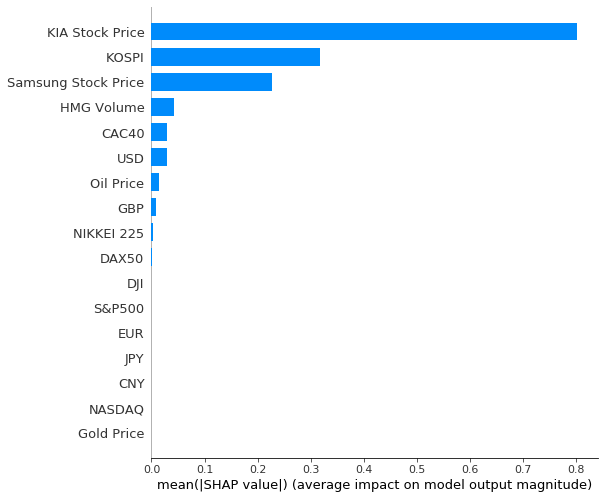

In [399]:
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar')